---
* ***ELGHAZI Soufiane***
---

<h1 style='color:purple' align='center'>La Classification d’Images avec
Techniques de Deep Learning</h1>

---

> Dans ce Notebook, nous allons Approfondir la compréhension et l’application de techniques avancées en deep learning pour la classification d’images.
---

**Monter Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os


# Dézipper le fichier
with zipfile.ZipFile('/content/drive/MyDrive/Data_Papillion.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/')

# Afficher un message une fois l'extraction terminée
print('Le fichier /content/drive/MyDrive/Data_Papillion.zip a été extrait avec succès dans le répertoire /content/drive/MyDrive/.')


Le fichier /content/drive/MyDrive/Data_Papillion.zip a été extrait avec succès dans le répertoire /content/drive/MyDrive/.


---
> The dataset features 75 different classes of Butterflies. The dataset contains about 1000+ labelled images including the validation images. Each image belongs to only one butterfly category.

The label of each image are saved in Training_set.csv.

Here is the Link: https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification/data
---

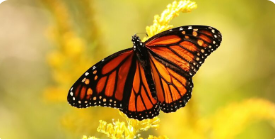


<h2 style="color:blue">2.1 Transfert de l’Apprentissage</h2>

<h3 style="color:purple">Importer les packages nécessaires</h3>

In [3]:
!pip install scikeras

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import shutil
import time
from tqdm import tqdm

from scipy.stats import uniform

from sklearn.model_selection import train_test_split , GridSearchCV , RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten , Dropout, BatchNormalization
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.utils import plot_model
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.regularizers import l1, l2

**Définir les chemins**

In [5]:
# Path dataset
train_csv = "/content/drive/MyDrive/Data_Papillion/Classes.csv"
train_folder = "/content/drive/MyDrive/Data_Papillion/Images/"

**Charger le fichier CSV contenant les classes**

In [6]:
train_df = pd.read_csv(train_csv)
train_df

filename                     label
0       Image_1.jpg          SOUTHERN DOGFACE
1       Image_2.jpg                    ADONIS
2       Image_3.jpg            BROWN SIPROETA
3       Image_4.jpg                   MONARCH
4       Image_5.jpg  GREEN CELLED CATTLEHEART
..              ...                       ...
995   Image_996.jpg               COPPER TAIL
996   Image_997.jpg           ORCHARD SWALLOW
997   Image_998.jpg             SLEEPY ORANGE
998   Image_999.jpg             QUESTION MARK
999  Image_1000.jpg             SLEEPY ORANGE

[1000 rows x 2 columns]

**Afficher le nombre de classes et le nombre d'occurrences pour chaque classe**

In [7]:
class_counts = train_df['label'].value_counts()

num_classes = len(class_counts)
print(f"Nombre de classes : {num_classes}")

for label, count in class_counts.items():
    print(f"Classe {label} : {count} occurrences")

Nombre de classes : 75
Classe MOURNING CLOAK : 22 occurrences
Classe BROWN SIPROETA : 21 occurrences
Classe TROPICAL LEAFWING : 21 occurrences
Classe GREEN CELLED CATTLEHEART : 18 occurrences
Classe RED POSTMAN : 18 occurrences
Classe ATALA : 18 occurrences
Classe BLACK HAIRSTREAK : 18 occurrences
Classe CABBAGE WHITE : 18 occurrences
Classe SLEEPY ORANGE : 17 occurrences
Classe DANAID EGGFLY : 17 occurrences
Classe RED SPOTTED PURPLE : 17 occurrences
Classe MILBERTS TORTOISESHELL : 17 occurrences
Classe COMMON WOOD-NYMPH : 17 occurrences
Classe CRECENT : 16 occurrences
Classe PURPLISH COPPER : 16 occurrences
Classe ADONIS : 16 occurrences
Classe ELBOWED PIERROT : 16 occurrences
Classe EASTERN COMA : 16 occurrences
Classe METALMARK : 15 occurrences
Classe ORCHARD SWALLOW : 15 occurrences
Classe ORANGE OAKLEAF : 15 occurrences
Classe MESTRA : 15 occurrences
Classe EASTERN DAPPLE WHITE : 15 occurrences
Classe LARGE MARBLE : 15 occurrences
Classe BANDED ORANGE HELICONIAN : 15 occurrences


**Afficher 5 images aléatoire**

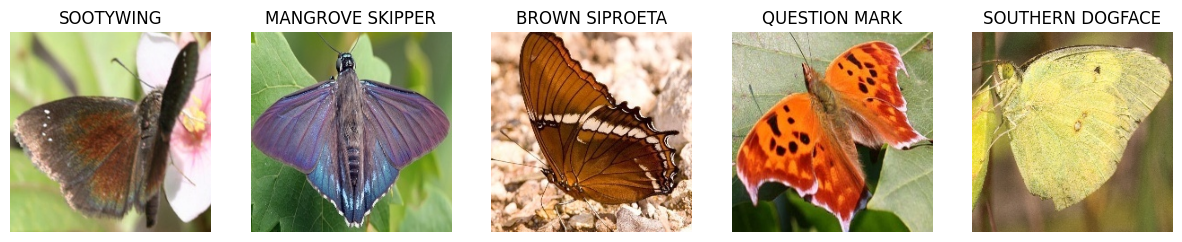

In [ ]:
sample_size = 5
fig, axes = plt.subplots(1, sample_size, figsize=(15, 3))
for i in range(sample_size):
    sample = train_df.sample(1)
    image_path = os.path.join(train_folder, sample['filename'].values[0])

    img = load_img(image_path, target_size=(224, 224))
    axes[i].imshow(img)
    axes[i].set_title(sample['label'].values[0])
    axes[i].axis('off')

plt.show()

**Distribution des classes de papillions**

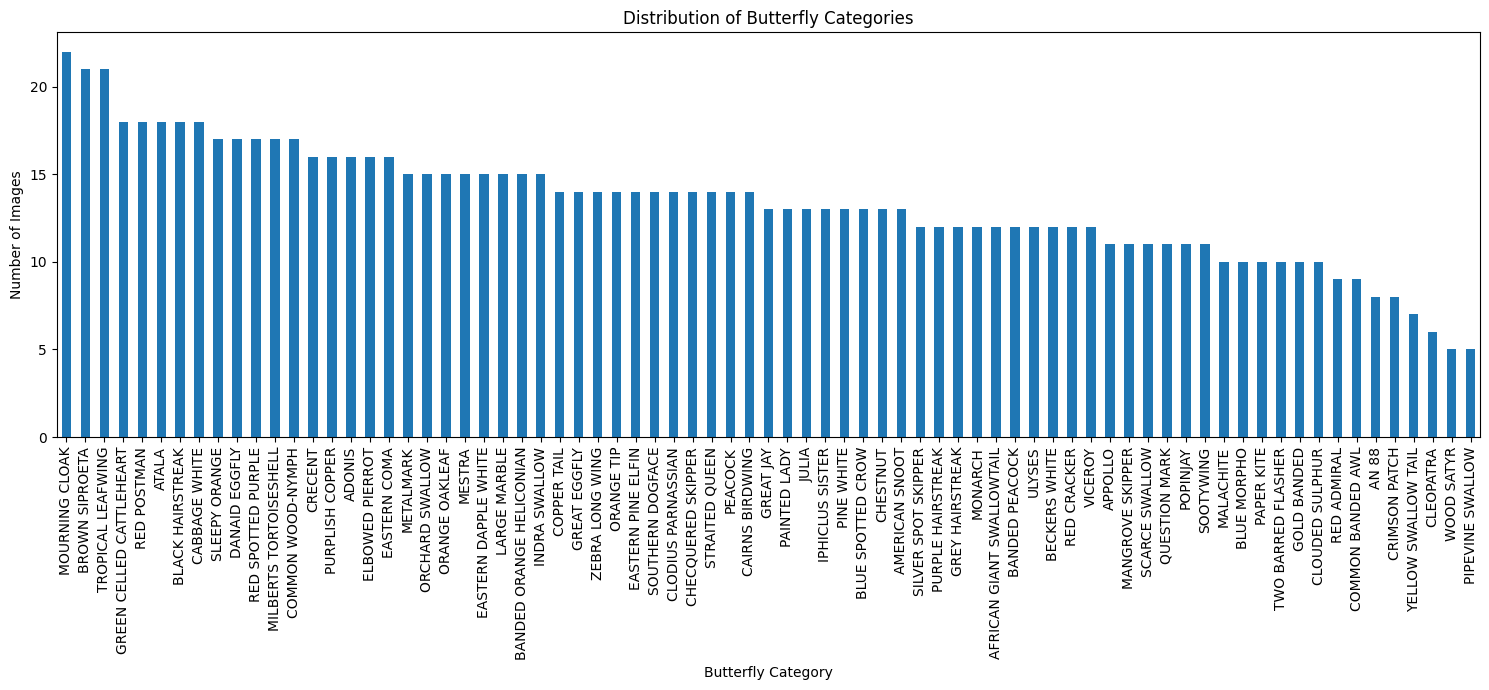

In [ ]:
plt.figure(figsize=(15, 7))
train_df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Butterfly Categories')
plt.xlabel('Butterfly Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**définir les Hyperparameter et afficher la liste des classes**

In [8]:
image_size = (150, 150)
batch_size = 32
epochs = 50
learning_rate = 0.0001

class_name = list(set(train_df['label']))
#print(class_name)

**Preprocessing Images**

In [11]:
features = []
labels = []

for image in tqdm(os.listdir(train_folder), desc="Preprocess Image"):
    label_name = train_df.loc[train_df['filename'] == image, 'label'].values[0]
    label = class_name.index(label_name)

    try:
        image_path = os.path.join(train_folder, image)
        image_read = cv2.imread(image_path)

        if image_read is not None:
            image_resized = cv2.resize(image_read, image_size)
            image_normalized = image_resized / 255.0
            features.append(image_normalized)
            labels.append(label)
        else:
            print(f"Error loading image: {image_path}")

    except Exception as e:
        print(f"Error processing image: {image}, Error: {e}")

print(len(features))
print(len(labels))

Preprocess Image: 100%|██████████| 1000/1000 [00:13<00:00, 74.53it/s]

1000
1000


**Deviser le jeu de données**

In [12]:
features = np.asarray(features)
labels = np.asarray(labels)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=42)

In [13]:
del features
del labels

<h3 style="color:red">Utiliser MobileNet</h3>

**Charger les modèles pré-entraîné sans la couche fully connected (top layer)**

In [ ]:
base_model_extraction = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3),
)

base_model_tuning = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3),
)

9406464/9406464 [==============================] - 1s 0us/step


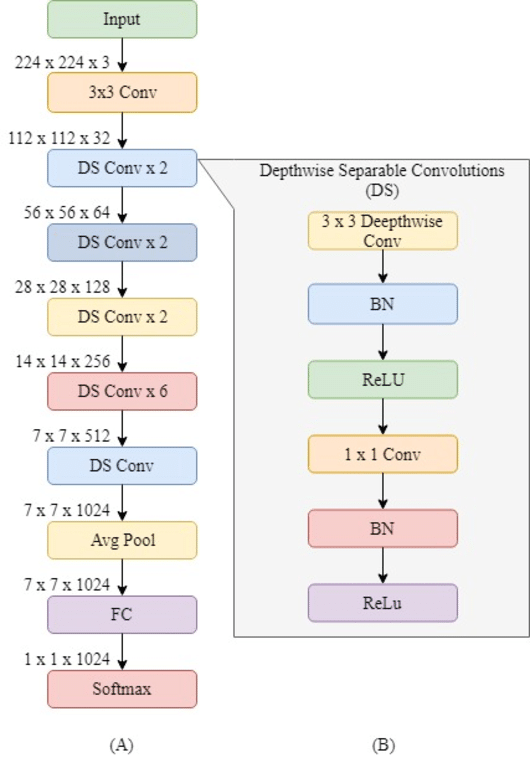

**1. Feature Extraction :**

In [ ]:
# Geler les poids du modèle pré-entraîné
for layer in base_model_extraction.layers:
    layer.trainable = False

# Ajouter des nouvelles couches pour la nouvelle tâche
x = base_model_extraction.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
predictions = Dense(75, activation='softmax')(x)

# Créer le modèle pour l'extraction de caractéristiques
feature_extraction_model = Model(inputs=base_model_extraction.input, outputs=predictions)
feature_extraction_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 75, 75, 32)           0         ['bn_Conv1[0][0]']        

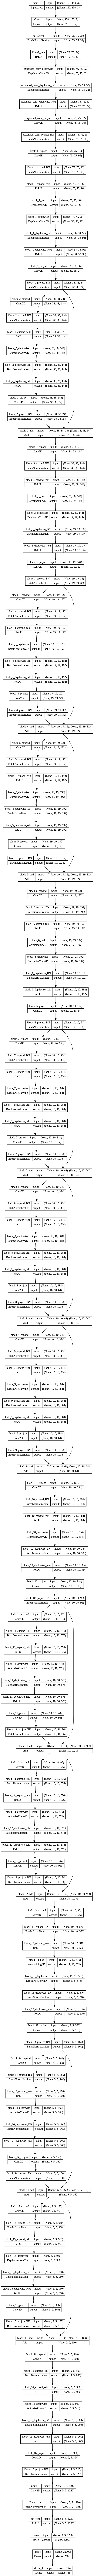

In [ ]:
plot_model(feature_extraction_model, to_file='feature_extraction_model.png', show_shapes=True)

In [ ]:
# Compiler le modèle
feature_extraction_model.compile(optimizer=Adam(learning_rate),
                                 loss='sparse_categorical_crossentropy',
                                 metrics=['accuracy'])
# Mesure du temps d'entraînement
start_time = time.time()

In [ ]:
# entrainer le modele
history_extraction = feature_extraction_model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data = (X_valid,y_valid),
    batch_size = batch_size,
)

end_time = time.time()
print("Training Time", end_time - start_time)

Epoch 1/100
22/22 [==============================] - 13s 116ms/step - loss: 9.3876 - accuracy: 0.1100 - val_loss: 8.1423 - val_accuracy: 0.2600
Epoch 2/100
22/22 [==============================] - 1s 37ms/step - loss: 6.0442 - accuracy: 0.7143 - val_loss: 7.0059 - val_accuracy: 0.4067
Epoch 3/100
22/22 [==============================] - 1s 38ms/step - loss: 4.7051 - accuracy: 0.9586 - val_loss: 6.5526 - val_accuracy: 0.4400
Epoch 4/100
22/22 [==============================] - 1s 37ms/step - loss: 4.2740 - accuracy: 1.0000 - val_loss: 6.0475 - val_accuracy: 0.5200
Epoch 5/100
22/22 [==============================] - 1s 36ms/step - loss: 4.0470 - accuracy: 1.0000 - val_loss: 5.8565 - val_accuracy: 0.4933
Epoch 6/100
22/22 [==============================] - 1s 38ms/step - loss: 3.8560 - accuracy: 1.0000 - val_loss: 5.6620 - val_accuracy: 0.5067
Epoch 7/100
22/22 [==============================] - 1s 40ms/step - loss: 3.6806 - accuracy: 1.0000 - val_loss: 5.4748 - val_accuracy: 0.5133
Epoc

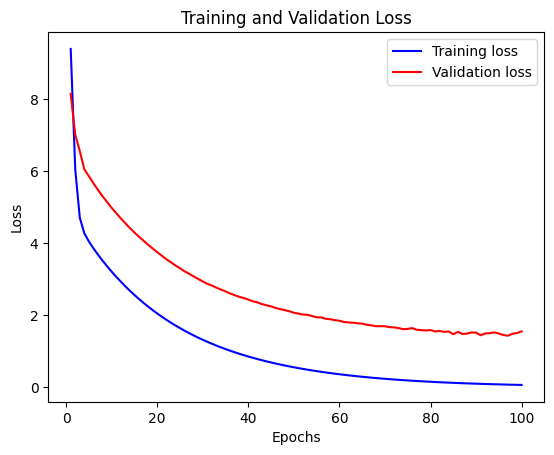

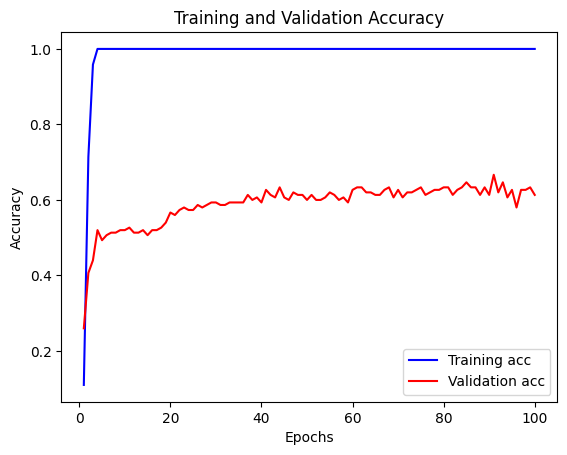

In [ ]:
# Visualiser les courbes des métriques
loss = history_extraction.history['loss']
val_loss = history_extraction.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history_extraction.history['accuracy']
val_acc = history_extraction.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

    On remarque que le modele overfit par la technique de Feature Extraction 

**2. Fine-Tuning :**

In [ ]:
# Déterminer le nombre de couches à entraîner
num_layers_to_train = int(np.ceil(0.2 * len(base_model_tuning.layers)))

# Geler certaines couches et en laisser d'autres non gelées
for layer in base_model_tuning.layers[:num_layers_to_train]:
    layer.trainable = False
for layer in base_model_tuning.layers[num_layers_to_train:]:
    layer.trainable = True

# Ajouter des nouvelles couches pour la nouvelle tâche
x = base_model_tuning.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
predictions = Dense(75, activation='softmax')(x)

# Créer le modèle pour le fine-tuning
fine_tuning_model = Model(inputs=base_model_tuning.input, outputs=predictions)
fine_tuning_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 75, 75, 32)           0         ['bn_Conv1[0][0]']      

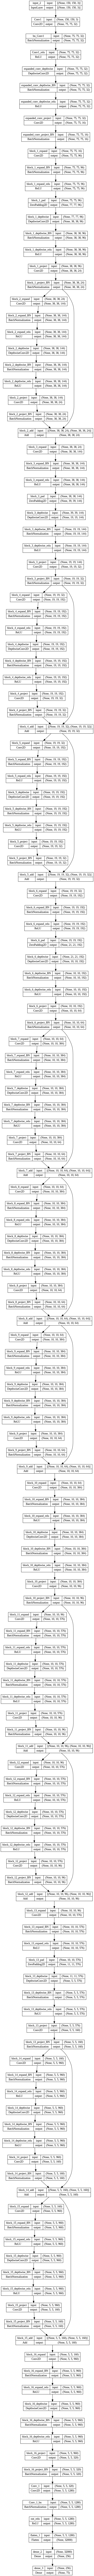

In [ ]:
plot_model(fine_tuning_model, to_file='fine_tuning_model.png', show_shapes=True)

In [ ]:
# Compiler le modèle
fine_tuning_model.compile(optimizer=Adam(learning_rate),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
# Mesure du temps d'entraînement
start_time = time.time()

In [ ]:
# entrainer le modele
epochs = 50

history_tuning = fine_tuning_model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    batch_size=batch_size,
)


end_time = time.time()
print("Training Time", end_time - start_time)

Epoch 1/100
22/22 [==============================] - 30s 124ms/step - loss: 9.2734 - accuracy: 0.0800 - val_loss: 8.8852 - val_accuracy: 0.1267
Epoch 2/100
22/22 [==============================] - 1s 61ms/step - loss: 5.7826 - accuracy: 0.8457 - val_loss: 8.7917 - val_accuracy: 0.1733
Epoch 3/100
22/22 [==============================] - 2s 69ms/step - loss: 4.7276 - accuracy: 0.9943 - val_loss: 8.6674 - val_accuracy: 0.2067
Epoch 4/100
22/22 [==============================] - 2s 82ms/step - loss: 4.5034 - accuracy: 1.0000 - val_loss: 8.4223 - val_accuracy: 0.1933
Epoch 5/100
22/22 [==============================] - 1s 68ms/step - loss: 4.3321 - accuracy: 1.0000 - val_loss: 8.0842 - val_accuracy: 0.1933
Epoch 6/100
22/22 [==============================] - 2s 69ms/step - loss: 4.1664 - accuracy: 1.0000 - val_loss: 7.8599 - val_accuracy: 0.1867
Epoch 7/100
22/22 [==============================] - 1s 62ms/step - loss: 4.0008 - accuracy: 1.0000 - val_loss: 7.6150 - val_accuracy: 0.1933
Epoc

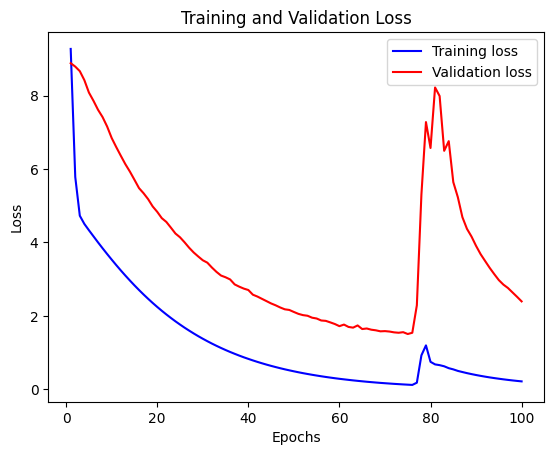

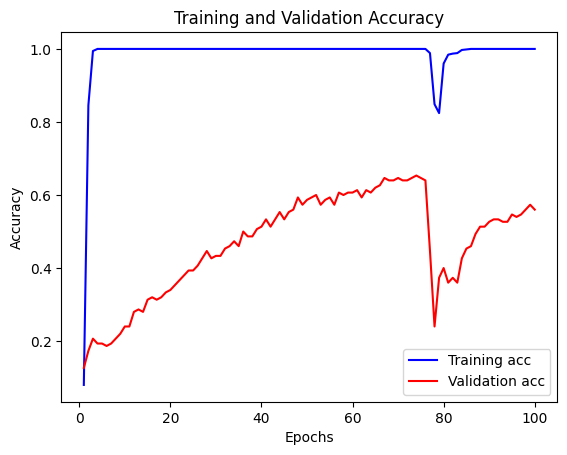

In [ ]:
# Tracer les courbes des metriques d'evaluation
loss = history_tuning.history['loss']
val_loss = history_tuning.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history_tuning.history['accuracy']
val_acc = history_tuning.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

     le modèle n'est pas stable

<h3 style="color:purple">Analyse</h3>

    L'analyse des avantages et des limites du transfert de l'apprentissage dans le contexte de la classification d'images révèle deux stratégies principales : l'extraction de caractéristiques (feature extraction) et l'affinage (fine-tuning). La première stratégie consiste à utiliser un modèle pré-entraîné pour extraire des caractéristiques pertinentes, puis à entraîner un nouveau classificateur sur ces caractéristiques. Cela permet de tirer parti des connaissances préalables du modèle de base. Cependant, cette approche peut rencontrer des limites si les caractéristiques extraites ne sont pas parfaitement adaptées à la tâche cible. En revanche, le fine-tuning implique d'ajuster les poids du modèle pré-entraîné pour la nouvelle tâche. Bien que cela puisse améliorer la performance en adaptant le modèle aux spécificités de la nouvelle tâche, il nécessite souvent une grande quantité de données annotées. Ainsi, le choix entre ces stratégies dépend des caractéristiques de la tâche et des ressources disponibles, soulignant la nécessité d'une approche réfléchie pour maximiser les bénéfices du transfert de l'apprentissage en classification d'images.

<h2 style="color:blue">2.2 Réseaux de Neurones Profonds avec Connexions Résiduelles</h2>

<h3 style="color:purple">1-Architecture</h3>

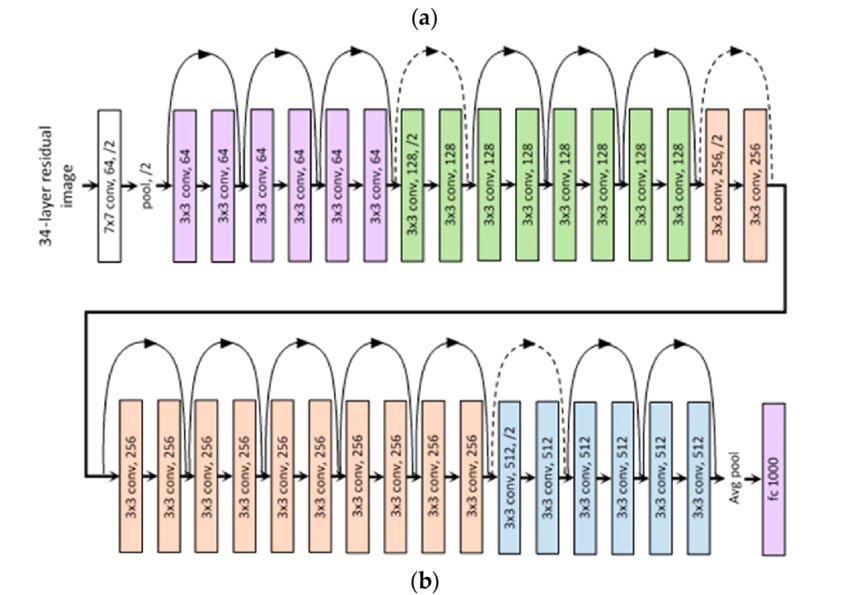

<h3 style="color:purple">2-Construire et entraîner un modèle ResNet(ResNet-50)</h3>

In [14]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3),
)

num_layers_to_train = int(np.ceil(0.2 * len(base_model.layers)))

for layer in base_model.layers[:num_layers_to_train] :
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
predictions = Dense(75, activation='softmax')(x)

model_res50 = Model(inputs=base_model.input, outputs=predictions)

#model_res50.summary()

94765736/94765736 [==============================] - 0s 0us/step


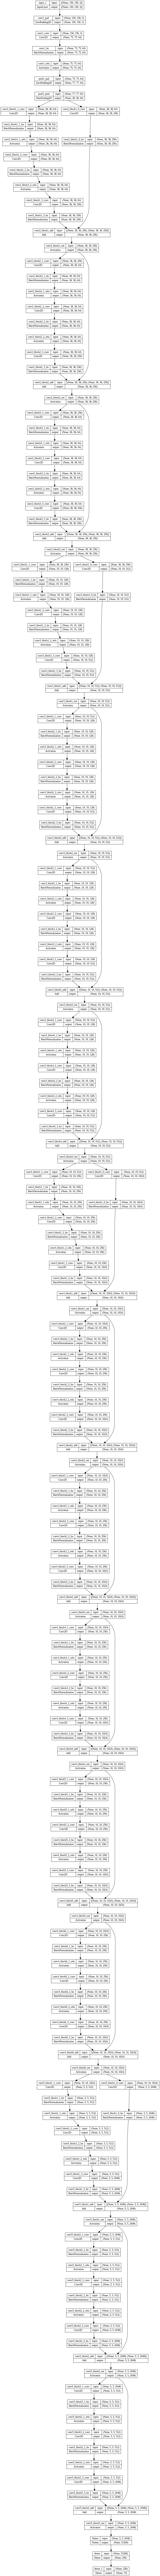

In [15]:
plot_model(model_res50, to_file='ResNet_model.png', show_shapes=True)

In [16]:
model_res50.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Temp d'entrainement
start_time = time.time()

In [17]:
epochs = 50
# Entrainement de modele
history = model_res50.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data = (X_valid,y_valid),
    batch_size = batch_size,
)

end_time = time.time()
print("Training Time", end_time - start_time)

Epoch 1/50
22/22 [==============================] - 48s 382ms/step - loss: 9.4356 - accuracy: 0.0786 - val_loss: 9.3939 - val_accuracy: 0.0133
Epoch 2/50
22/22 [==============================] - 3s 158ms/step - loss: 5.8915 - accuracy: 0.7886 - val_loss: 9.2879 - val_accuracy: 0.0133
Epoch 3/50
22/22 [==============================] - 3s 157ms/step - loss: 4.6940 - accuracy: 0.9929 - val_loss: 9.1637 - val_accuracy: 0.0133
Epoch 4/50
22/22 [==============================] - 3s 154ms/step - loss: 4.4238 - accuracy: 0.9986 - val_loss: 9.1517 - val_accuracy: 0.0133
Epoch 5/50
22/22 [==============================] - 3s 158ms/step - loss: 4.2132 - accuracy: 1.0000 - val_loss: 9.1871 - val_accuracy: 0.0200
Epoch 6/50
22/22 [==============================] - 4s 165ms/step - loss: 4.0185 - accuracy: 1.0000 - val_loss: 9.1348 - val_accuracy: 0.0067
Epoch 7/50
22/22 [==============================] - 4s 160ms/step - loss: 3.8310 - accuracy: 1.0000 - val_loss: 8.9423 - val_accuracy: 0.0200
Epoch

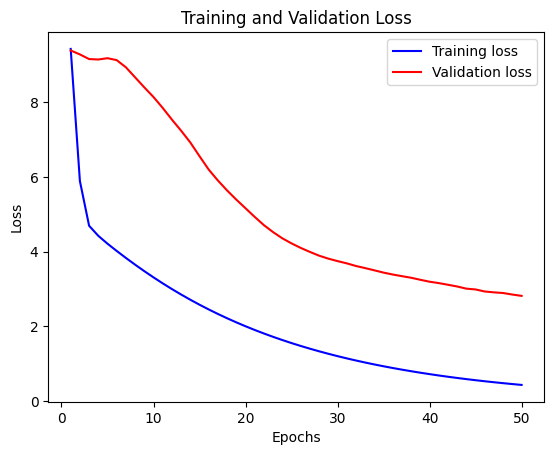

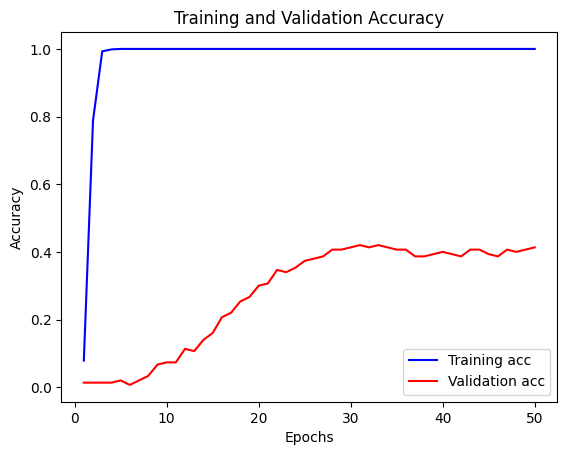

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

    en prenant par conséquent le nombre limité des images et des époques , les métriques de RESNET50 en donner des résultats assez bonnes.

<h3 style="color:purple">3-modèle
de réseau de neurones profond classique (sans connexions résiduelles)</h3>

In [ ]:
# Construire un modèle DNN classique
dnn_model = Sequential([
    Flatten(input_shape=(150, 150, 3)),
    Dense(256, activation='relu'),
    Dense(75, activation='softmax')
])
# Afficher le résumé du modèle DNN
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 67500)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               17280256  
                                                                 
 dense_7 (Dense)             (None, 75)                19275     
                                                                 
Total params: 17299531 (65.99 MB)
Trainable params: 17299531 (65.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


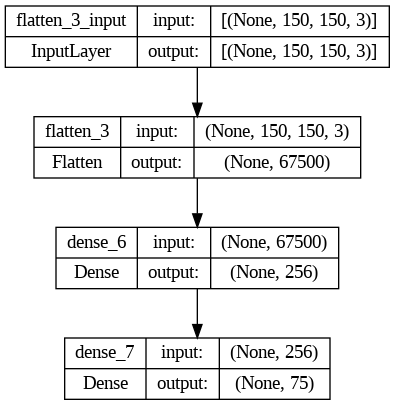

In [ ]:
plot_model(dnn_model, to_file='dnn_model.png', show_shapes=True)

In [ ]:
# Compiler le modèle DNN
dnn_model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs=50
# Entraîner le modèle DNN
history_dnn = dnn_model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    batch_size=batch_size,
)

Epoch 1/50
22/22 [==============================] - 2s 32ms/step - loss: 5.1782 - accuracy: 0.0286 - val_loss: 4.3600 - val_accuracy: 0.0200
Epoch 2/50
22/22 [==============================] - 0s 17ms/step - loss: 4.2070 - accuracy: 0.0471 - val_loss: 4.3989 - val_accuracy: 0.0400
Epoch 3/50
22/22 [==============================] - 0s 19ms/step - loss: 4.1346 - accuracy: 0.0571 - val_loss: 4.3756 - val_accuracy: 0.0333
Epoch 4/50
22/22 [==============================] - 0s 18ms/step - loss: 4.0955 - accuracy: 0.0614 - val_loss: 4.3777 - val_accuracy: 0.0333
Epoch 5/50
22/22 [==============================] - 0s 17ms/step - loss: 4.0316 - accuracy: 0.0700 - val_loss: 4.2775 - val_accuracy: 0.0267
Epoch 6/50
22/22 [==============================] - 0s 17ms/step - loss: 3.9442 - accuracy: 0.0786 - val_loss: 4.2824 - val_accuracy: 0.0267
Epoch 7/50
22/22 [==============================] - 0s 17ms/step - loss: 3.8847 - accuracy: 0.0929 - val_loss: 4.3578 - val_accuracy: 0.0733
Epoch 8/50
22

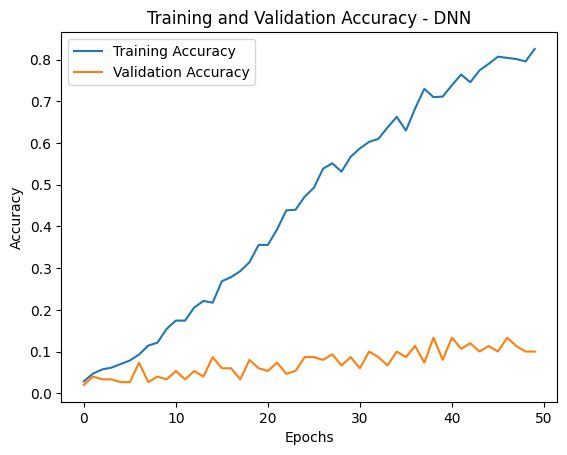

In [ ]:
# Afficher les courbes d'apprentissage du modèle DNN
plt.plot(history_dnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy - DNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<h3 style="color:purple">4-Evaluation</h3>

    Le modèle ResNet, en introduisant des connexions résiduelles, vise à faciliter le flux d'informations et à atténuer les problèmes de rétropropagation, favorisant ainsi un entraînement plus efficace. Les observations de l'évolution de la perte et de la précision permettront de déterminer si le ResNet converge plus rapidement et atteint éventuellement une meilleure performance que le modèle classique. Il est attendu que le ResNet présente une réduction plus rapide de la perte et une amélioration plus marquée de la précision, démontrant ainsi les avantages des connexions résiduelles dans la gestion des défis liés à l'entraînement de réseaux de neurones profonds. Cette analyse approfondie contribuera à une compréhension plus fine des mécanismes sous-jacents et à une prise de décision informée quant au choix de l'architecture pour une tâche donnée.

<h2 style="color:blue">2.3 Optimisation des Hyperparamètres</h2>

In [ ]:
class CustomKerasClassifier(KerasClassifier):
    def __init__(self, learning_rate=0.001, *args, **kwargs):
        self.learning_rate = learning_rate
        super().__init__(*args, **kwargs)

    def create_resnet_model(self, optimizer='adam', compile_kwargs=None):
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(image_size[0], image_size[1], 3),
        )

        num_layers_to_train = int(np.ceil(0.2 * len(base_model.layers)))

        for layer in base_model.layers[:num_layers_to_train]:
            layer.trainable = False

        x = base_model.output
        x = Flatten()(x)
        x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
        predictions = Dense(75, activation='softmax')(x)

        model = Model(inputs=base_model.input, outputs=predictions)
        model.compile(optimizer=Adam(learning_rate=self.learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        return model

    def _keras_build_fn(self, compile_kwargs=None, **kwargs):
        kwargs.pop('meta', None)
        kwargs.pop('compile_kwargs', None)
        kwargs.pop('params', None)
        return self.create_resnet_model(**kwargs, compile_kwargs=compile_kwargs)

<h3 style="color:purple">1-la recherche par grille</h3>

In [ ]:
# Définir les hyperparamètres à tester
param_grid = {
    'learning_rate': [0.001, 0.01],
}

# Créer l'estimateur pour la recherche par grille
model = CustomKerasClassifier(epochs=10, batch_size=32, verbose=0)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid_search.fit(X_train, y_train)

# Afficher les résultats
print(f"Best F1 Score: {grid_result.best_score_} using {grid_result.best_params_}")


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Best F1 Score: 0.020004157343213137 using {'learning_rate': 0.01}


<h3 style="color:purple">2-la recherche aléatoire</h3>

In [ ]:
param_dist = {
    'learning_rate': uniform(0.001, 0.01 - 0.001),
}

model = CustomKerasClassifier(epochs=10, batch_size=32, verbose=0)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    random_state=42,
    n_jobs=-1
)

# Exécuter la recherche aléatoire
random_result = random_search.fit(X_train, y_train)

# Afficher les résultats
print(f"Best F1 Score: {random_result.best_score_} using {random_result.best_params_}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-package

Best F1 Score: 0.019998043603193818 using {'learning_rate': 0.0015227525095137954}


<h3 style="color:purple">4- Evaluation et Comparaison</h3>

    La recherche par grille consiste à définir une grille de valeurs pour les hyperparamètres et à évaluer systématiquement chaque combinaison possible. Cette approche a l'avantage d'explorer de manière exhaustive l'espace des hyperparamètres, mais elle peut souffrir d'un coût élevé en termes de ressources computationnelles, surtout lorsque l'espace de recherche est vaste. En revanche, la recherche aléatoire sélectionne des combinaisons d'hyperparamètres de manière aléatoire, ce qui peut être plus efficace en termes de ressources, mais avec une probabilité moindre de trouver la meilleure configuration.

<h2 style="color:blue">2.4 Techniques de Régularisation</h2>

<h3 style="color:purple">Fonction pour créer le modèle avec régularisation</h3>

In [ ]:
# Fonction pour créer le modèle avec régularisation
def create_regularized_model(dropout_rate=0.5, l1_penalty=0.001, l2_penalty=0.001, use_batch_norm=False):
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(image_size[0], image_size[1], 3),
    )

    num_layers_to_train = int(np.ceil(0.2 * len(base_model.layers)))

    for layer in base_model.layers[:num_layers_to_train]:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)

    # Ajouter Dropout
    x = Dropout(dropout_rate)(x)

    # Ajouter Régularisation L1 ou L2 (pas les deux)
    if l1_penalty > 0:
        x = Dense(256, activation='relu', kernel_regularizer=l1(l1_penalty))(x)
    elif l2_penalty > 0:
        x = Dense(256, activation='relu', kernel_regularizer=l2(l2_penalty))(x)

    # Ajouter Normalisation par lots (Batch Normalisation)
    if use_batch_norm:
        x = BatchNormalization()(x)

    predictions = Dense(75, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


**Créer et entraîner le modèle sans régularisation**

In [ ]:
model_no_regularization = create_regularized_model(dropout_rate=0.0, l1_penalty=0.0, l2_penalty=0.0, use_batch_norm=False)
history_no_regularization = model_no_regularization.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
22/22 [==============================] - 33s 266ms/step - loss: 9.6217 - accuracy: 0.0171 - val_loss: 590.9644 - val_accuracy: 0.0000e+00
Epoch 2/10
22/22 [==============================] - 4s 170ms/step - loss: 4.3997 - accuracy: 0.0386 - val_loss: 103.0518 - val_accuracy: 0.0200
Epoch 3/10
22/22 [==============================] - 4s 162ms/step - loss: 3.5589 - accuracy: 0.1586 - val_loss: 27.2460 - val_accuracy: 0.0000e+00
Epoch 4/10
22/22 [==============================] - 4s 161ms/step - loss: 2.5508 - accuracy: 0.3500 - val_loss: 8.8550 - val_accuracy: 0.0067
Epoch 5/10
22/22 [==============================] - 3s 159ms/step - loss: 1.3362 - accuracy: 0.6514 - val_loss: 6.2118 - val_accuracy: 0.0067
Epoch 6/10
22/22 [==============================] - 4s 166ms/step - loss: 0.4954 - accuracy: 0.8614 - val_loss: 4.6710 - val_accuracy: 0.0467
Epoch 7/10
22/22 [==============================] - 4s 168ms/step - loss: 0.2253 - accuracy: 0.9414 - val_loss: 4.8427 - val_accuracy:

**Créer et entraîner le modèle avec régularisation**

In [ ]:
model_with_regularization = create_regularized_model(dropout_rate=0.5, l1_penalty=0.001, l2_penalty=0.001, use_batch_norm=True)
history_with_regularization = model_with_regularization.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
22/22 [==============================] - 35s 223ms/step - loss: 52.3789 - accuracy: 0.0486 - val_loss: 60.3019 - val_accuracy: 0.0067
Epoch 2/10
22/22 [==============================] - 4s 164ms/step - loss: 28.7624 - accuracy: 0.1886 - val_loss: 36.7379 - val_accuracy: 0.0000e+00
Epoch 3/10
22/22 [==============================] - 4s 170ms/step - loss: 18.0352 - accuracy: 0.3571 - val_loss: 20.5774 - val_accuracy: 0.0067
Epoch 4/10
22/22 [==============================] - 4s 170ms/step - loss: 13.9582 - accuracy: 0.5371 - val_loss: 17.6550 - val_accuracy: 0.0067
Epoch 5/10
22/22 [==============================] - 4s 166ms/step - loss: 11.3581 - accuracy: 0.7786 - val_loss: 14.8720 - val_accuracy: 0.0267
Epoch 6/10
22/22 [==============================] - 4s 169ms/step - loss: 9.4321 - accuracy: 0.9057 - val_loss: 14.2251 - val_accuracy: 0.0133
Epoch 7/10
22/22 [==============================] - 4s 171ms/step - loss: 9.3471 - accuracy: 0.8829 - val_loss: 13.8614 - val_accura

**Évaluer les performances des modèles**

In [ ]:
y_pred_no_regularization = model_no_regularization.predict(X_test)
y_pred_no_regularization = np.argmax(y_pred_no_regularization, axis=1)

y_pred_with_regularization = model_with_regularization.predict(X_test)
y_pred_with_regularization = np.argmax(y_pred_with_regularization, axis=1)

accuracy_no_regularization = accuracy_score(y_test, y_pred_no_regularization)
accuracy_with_regularization = accuracy_score(y_test, y_pred_with_regularization)

print(f"Accuracy without regularization: {accuracy_no_regularization}")
print(f"Accuracy with regularization: {accuracy_with_regularization}")

5/5 [==============================] - 2s 64ms/step
Accuracy without regularization: 0.04666666666666667
Accuracy with regularization: 0.04


* Dropout :
Le dropout consiste à aléatoirement "éteindre" certains neurones pendant l'entraînement, forçant ainsi le modèle à apprendre des représentations plus robustes. Cette technique est efficace pour réduire le surajustement en introduisant une forme de bruit dans le réseau. Cela peut améliorer la généralisation du modèle. Cependant, un dropout excessif peut ralentir l'entraînement et diminuer la précision, nécessitant un équilibre subtil dans son utilisation.

* Régularisation L1/L2 :
La régularisation L1 ajoute une pénalité proportionnelle à la valeur absolue des poids du modèle, tandis que la régularisation L2 ajoute une pénalité proportionnelle au carré des poids. Ces techniques visent à prévenir le surajustement en limitant la complexité du modèle. Elles peuvent améliorer la généralisation, mais une pénalité excessive peut entraîner une sous-ajustement. L'impact sur la vitesse d'entraînement dépend de la force de la régularisation.

* Normalisation par lots (Batch Normalization) :
La normalisation par lots normalise les activations d'une couche en utilisant la moyenne et l'écart type des activations de l'ensemble du lot. Cela peut accélérer l'entraînement en réduisant le problème du décalage covariant, favorisant ainsi une convergence plus rapide. De plus, Batch Normalization agit comme une forme de régularisation, réduisant potentiellement le besoin d'autres méthodes de régularisation. Cependant, son impact peut varier selon la nature de la tâche.

<h2 style="color:blue">2.5 Visualisation des Caractéristiques Apprises</h2>

In [19]:
model_res50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

<h3 style="color:purple">Cartes d’Activation (Activation Maps)</h3>

In [20]:
# Function to plot activation maps
def plot_activation_maps(model, layer_name, img):
    activation_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    activation = activation_model.predict(np.expand_dims(img, axis=0))

    # Calculate the number of rows and columns based on the number of channels
    num_channels = activation.shape[-1]
    num_rows = (num_channels // 8) + 1
    num_cols = min(num_channels, 8)

    plt.figure(figsize=(16, 2 * num_rows))

    for i in range(num_channels):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(activation[0, :, :, i], cmap='viridis')
        plt.axis('off')

    plt.show()

1/1 [==============================] - 0s 355ms/step


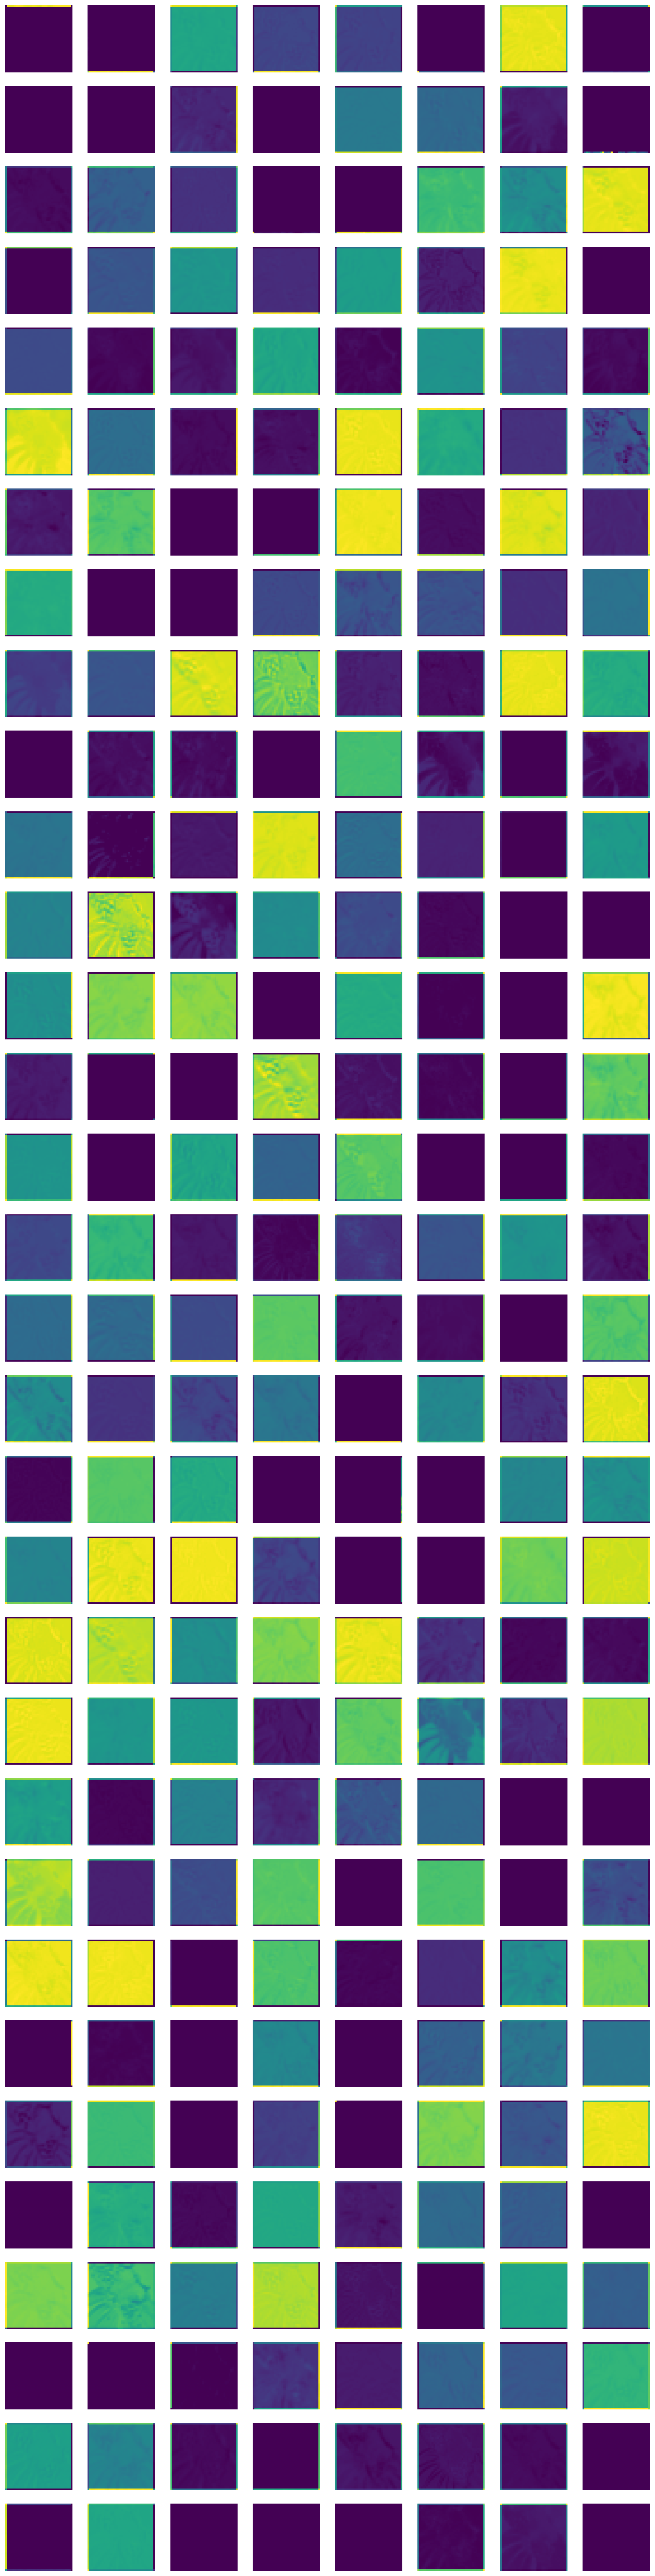

In [22]:
layer_name = 'conv2_block1_out'
sample_image = X_test[0]
# Plot activation maps for the chosen layer
plot_activation_maps(model_res50, layer_name, sample_image)


<h3 style="color:purple">Filtres de Convolution</h3>

In [24]:
# Function to plot convolution filters
def plot_convolution_filters(model, layer_name):
    filters, biases = model.get_layer(layer_name).get_weights()
    # Normalize filter values to range [0, 1] for better visualization
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    n_filters, ix = filters.shape[3], 1

    # Calculate the number of rows and columns based on the number of filters
    num_rows = (n_filters // 8) + 1
    num_cols = min(n_filters, 8)

    plt.figure(figsize=(16, 2 * num_rows))

    for i in range(n_filters):
        f = filters[:, :, :, i]
        ax = plt.subplot(num_rows, num_cols, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:, :, 0], cmap='gray')
        ix += 1

    plt.show()

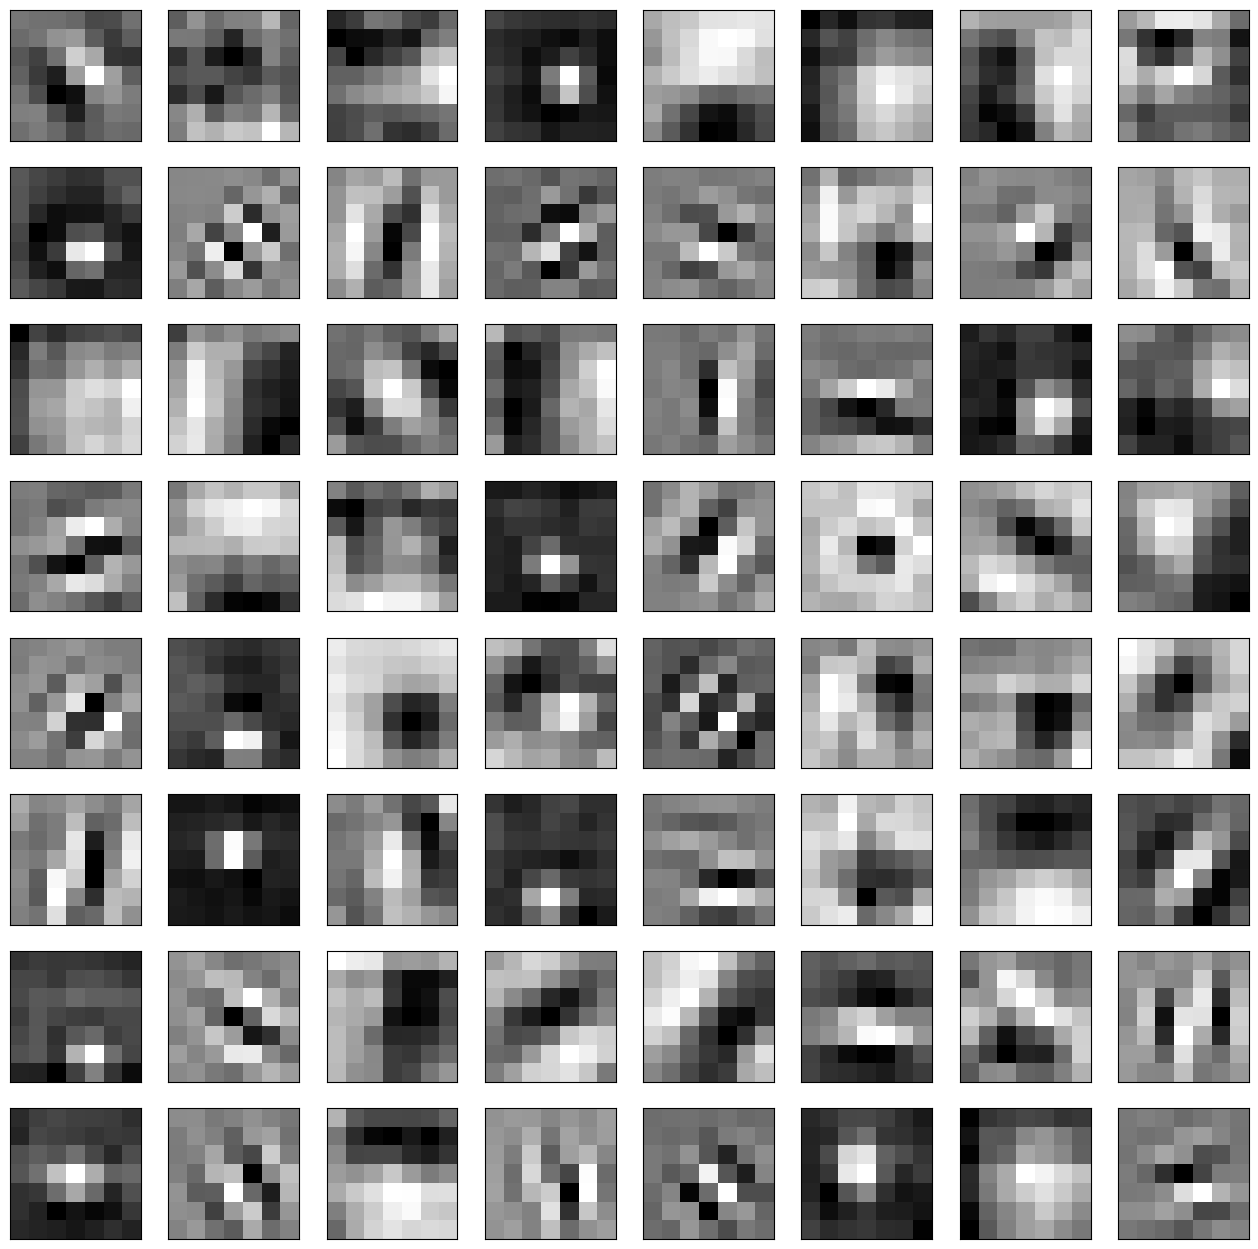

In [25]:
conv_layer_name = 'conv1_conv'
# Plot convolution filters for the chosen layer
plot_convolution_filters(model_res50, conv_layer_name)

En utilisant ces visualisations conjointement, on peut déduire comment le modèle perçoit des caractéristiques de plus en plus abstraites à mesure que l'information traverse le réseau. Par exemple, les premières couches peuvent se concentrer sur des détails tels que les contours et les textures, tandis que les couches plus profondes peuvent représenter des objets complets ou des structures complexes.

Ces analyses visuelles aident également les chercheurs et les praticiens à diagnostiquer d'éventuels problèmes de surajustement (overfitting) ou de sous-ajustement (underfitting) en observant comment le modèle réagit aux données d'entraînement et de validation. En résumé, les filtres de convolution et les cartes d'activation fournissent des outils essentiels pour interpréter le fonctionnement interne d'un modèle CNN et améliorer sa performance.

<h2 style="color:blue">2.7 Rapport et Conclusion</h2>

* L'évaluation détaillée des modèles entraînés dans le cadre du ce projet sur la classification d'images avec des techniques de deep learning a généré des résultats significatifs et des enseignements précieux. En utilisant des modèles pré-entraînés tels que VGG16 et ResNet, nous avons exploré les stratégies de transfert de l'apprentissage, notamment la feature extraction et le fine-tuning, sur un nouveau jeu de données de classification d'images. Les performances ont été analysées avec attention, mettant en lumière les avantages et les limites du transfert de l'apprentissage dans ce contexte spécifique.

* Lors de l'exploration des réseaux de neurones profonds avec connexions résiduelles, notamment ResNet, nous avons examiné l'impact des connexions de raccourci sur la résolution du problème de la disparition du gradient. La comparaison entre les performances de ResNet et d'un réseau classique sans connexions résiduelles a permis de constater les bénéfices des connexions de raccourci en termes de précision et de stabilité de l'entraînement.

* L'optimisation des hyperparamètres a été abordée à travers des méthodes de recherche par grille et aléatoire. Les performances des modèles avec différentes combinaisons d'hyperparamètres ont été comparées, mettant en évidence l'influence de ces choix sur la qualité du modèle. L'efficacité relative de la recherche par grille par rapport à la recherche aléatoire a été analysée, tenant compte du coût en temps et en ressources.

* Les techniques de régularisation, y compris le dropout, la régularisation L1/L2 et la normalisation par lots, ont été intégrées au modèle pour contrer le surajustement. L'impact de chaque méthode sur la performance a été évalué en termes de surajustement, de vitesse d'entraînement et de précision de la classification.

* En dépit des résultats positifs, des défis ont été rencontrés, notamment le coût élevé en termes de ressources computationnelles et les interruptions fréquentes lors de l'utilisation de Colab. Ces défis ont souligné l'importance de l'infrastructure informatique dans le domaine du deep learning et ont suscité une réflexion sur les moyens d'optimiser les workflows.

* En conclusion, cette expérience a fourni une compréhension approfondie des techniques avancées en deep learning pour la classification d'images. Les résultats et les enseignements tirés contribuent à guider de futures approches et soulignent l'importance de l'optimisation des hyperparamètres, de la régularisation et de l'utilisation judicieuse des modèles pré-entraînés dans des contextes spécifiques.


<h1 style='color:purple' align='center'>Fin</h1>

---